# Classic ML -- SVM 

## 0. Install necessary libraries

In [1]:
# Basic data analysis libraries 
import numpy as np
import pandas as pd

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# For data preprocessing and cleaning
import emoji 
from emoji import demojize, emojize

# NLP Libraries
import nltk
import spacy
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords # I dont want to use this one for now
from nltk.tokenize import word_tokenize
from spacy.lang.en import English

# For text preprocessing
import string
import contractions
from typing import List, Optional


# Sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline

## 1. Load data

In [2]:
# Read the data from the tsv file
def load_data(train_path, dev_path, text_path):
    train_df = pd.read_csv('/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/train.tsv', sep='\t')
    dev_df = pd.read_csv('/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/dev.tsv', sep='\t')
    test_df = pd.read_csv('/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/test.tsv', sep = '\t') 

    # Split the data into features and labels
    X_train = train_df.iloc[:, 0] # The first column is the tweets
    y_train = train_df.iloc[:, 1] # The second column is the labels

    # Follow the same steps for the dev set
    X_dev = dev_df.iloc[:, 0]
    y_dev = dev_df.iloc[:, 1]

    # Follow the same steps for the test set
    X_test = test_df.iloc[:, 0]
    y_test = test_df.iloc[:, 1]

    # Map the labels to integers
    label_map = {'OFF': 1, 'NOT': 0} # is this step necessary?
    y_train = y_train.map(label_map)
    y_dev = y_dev.map(label_map)
    y_test = y_test.map(label_map)

    return (X_train, y_train), (X_dev, y_dev), (X_test, y_test)

In [3]:
# Save the labels fro classification report
class_names = ['Offensive', 'Not Offensive']

## 1.1 Pre-processing  
1. URL & User Handling
2. Emoji Handling
3. Text standardisation
4. Class imbalance

In [4]:
class TextPreprocessor:
    """
    Class to handle text preprocessing for Twitter data
    """
    def __init__(self):
        # Common patterns
        self.url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        self.user_pattern = r'@[\w\d_]+'
        
        # Words with 3 or more repeated characters
        self.repeat_pattern = re.compile(r'(.)\1{2,}')
        
        # Optional: Initialize spacy if needed
        # self.nlp = spacy.load('en_core_web_sm')
    
    def standardize_special_tokens(self, text: str) -> str:
        """Standardize URLs and User mentions"""
        # Replace URLs with [URL]
        text = re.sub(self.url_pattern, '[URL]', text)
        # Replace @mentions with [USER]
        text = re.sub(self.user_pattern, '[USER]', text)
        return text
    
    def handle_emojis(self, text: str) -> str:
        """Convert emojis to text description"""
        try:
            return emoji.demojize(text, delimiters=(' [EMOJI_', '] '))
        except:
            # If emoji conversion fails, return original text
            return text
    
    def standardize_text(self, text: str) -> str:
        """Handle non-standard text features"""
        # Convert to lowercase
        text = text.lower()
        
        # Expand contractions
        try:
            text = contractions.fix(text)
        except:
            pass
        
        # Handle repeated characters (e.g., 'sooooo' -> 'soo')
        text = self.repeat_pattern.sub(r'\1\1', text)
        
        # Replace multiple spaces with single space
        text = re.sub(r'\s+', ' ', text)
        
        return text
    
    def preprocess(self, text: str, 
                  handle_emojis: bool = False, 
                  standardize_tokens: bool = False,
                  standardize_text: bool = True) -> str:
        """Main preprocessing function"""
        if not isinstance(text, str):
            return ''
            
        if standardize_tokens:
            text = self.standardize_special_tokens(text)
            
        if handle_emojis:
            text = self.handle_emojis(text)
            
        if standardize_text:
            text = self.standardize_text(text)
            
        return text.strip()

def create_preprocessing_pipeline():
    """Create preprocessing pipeline to be used in CountVectorizer"""
    preprocessor = TextPreprocessor()
    return preprocessor.preprocess

# Add this function to help analyze preprocessing results
def analyze_preprocessing(preprocessor: TextPreprocessor, texts: List[str], n_samples: int = 5):
    """Analyze the effect of preprocessing on sample texts"""
    print("Preprocessing Analysis:")
    print("-" * 50)
    
    for i, text in enumerate(texts[:n_samples]):
        print(f"\nExample {i+1}:")
        print("Original:", text)
        print("Preprocessed:", preprocessor.preprocess(text))
        print("-" * 50)

### 1.1.1 Pre-processing analysis

In [5]:
if __name__ == '__main__':
    # 1. Load the data first
    (X_train, y_train), (X_dev, y_dev), (X_test, y_test) = load_data(
        '/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/train.tsv', 
        '/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/dev.tsv', 
        '/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/test.tsv'
    )

    # 2. Create preprocessor and analyze samples
    preprocessor = TextPreprocessor()
    sample_texts = X_train.iloc[:5].tolist()
    analyze_preprocessing(preprocessor, sample_texts)

Preprocessing Analysis:
--------------------------------------------------

Example 1:
Original: @USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL
Preprocessed: @user @user go home you are drunk!! @user #maga #trump2020 👊🇺🇸👊 url
--------------------------------------------------

Example 2:
Original: Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT
Preprocessed: amazon is investigating chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. url #amazon #maga #kag #china #tcot
--------------------------------------------------

Example 3:
Original: @USER Someone should'veTaken" this piece of shit to a volcano. 😂"
Preprocessed: @user someone should'vetaken" this piece of shit to a volcano. 😂"
--------------------------------------------------

Example 4:
Original: @USER @U

## 2. Build model

In [6]:
def create_basic_svm(max_features=10000, ngram_range=(1, 1)):
    """
    Create a basic SVM model using the CountVectorizer and LinearSVC
    """
    # Create a pipeline
    pipeline = Pipeline([
        # CountVectorizer -> TfidfTransformer -> LinearSVC
        ('vectorizer', CountVectorizer(
            preprocessor=create_preprocessing_pipeline(),
            lowercase=True, # Or should I set it to False?
            max_features=max_features,
            ngram_range=ngram_range,
            strip_accents='unicode'
        )),
        ('tfidf', TfidfTransformer(
            norm='l2',      # Default normalization
            use_idf=True,   # Enable IDF
            smooth_idf=True # Prevents division by zero
        )),
        ('classifier', LinearSVC(class_weight='balanced'))
    ])
    return pipeline

In [7]:
# Train the model
def train_model(pipeline, X_train, y_train):
    """
    Train the model
    """
    pipeline.fit(X_train, y_train)
    return pipeline


## 3. Train & Evaluate

## 3.2 Evaluate and result print function

In [8]:
def evalute_model(pipeline, X, y, split_name=""): # Why?
    """
    Evaluate the model
    """
    # Get predictions
    y_pred = pipeline.predict(X)
    
    # Calculate metrics
    acc = accuracy_score(y, y_pred)
    class_report = classification_report(y, y_pred, output_dict= True, target_names=class_names)
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Print results 
    print(f"\nResults for {split_name} set:")
    print(f'Accuracy: {acc: .4f}')
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {split_name} set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return {
        "Accuracy": acc,
        "Classification Report": class_report,
        'Confusion Matrix': conf_matrix,
        'Predictions': y_pred
    }


## 4. Main execution


Results for Train set:
Accuracy:  0.9938

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8192
           1       0.99      0.99      0.99      4047

    accuracy                           0.99     12239
   macro avg       0.99      0.99      0.99     12239
weighted avg       0.99      0.99      0.99     12239



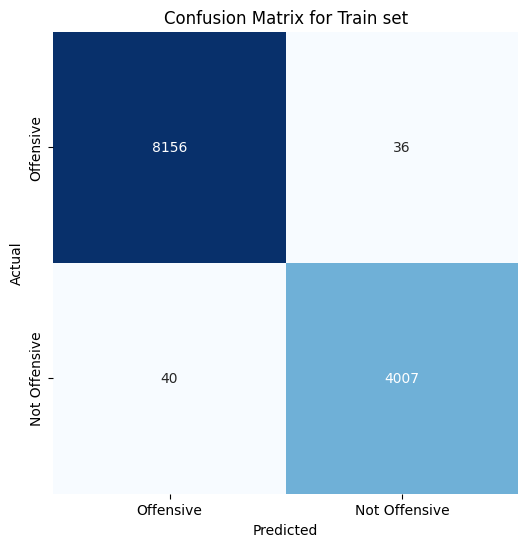


Results for Dev set:
Accuracy:  0.7297

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       647
           1       0.65      0.51      0.57       352

    accuracy                           0.73       999
   macro avg       0.70      0.68      0.69       999
weighted avg       0.72      0.73      0.72       999



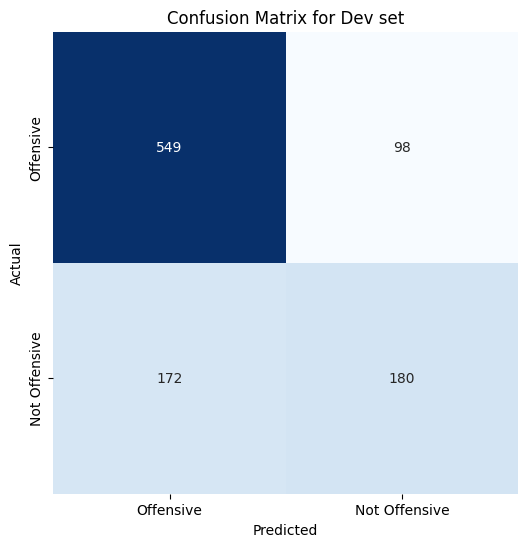

In [9]:
if __name__ == '__main__':
    # 1. Load the data
    (X_train, y_train), (X_dev, y_dev), (X_test, y_test) = load_data('/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/train.tsv', 
                                                                     '/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/dev.tsv', 
                                                                     '/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/test.tsv'
                                                                     )
    
    # 2. Create and train the pipeline 
    pipeline = create_basic_svm(
        max_features=100000, # May need to change it for testing
        ngram_range=(1, 2) # change uni-gram to bi-gram
    )
    
    pipeline = train_model(pipeline, X_train, y_train)
    
    # 3. Evaluate the model
    train_results = evalute_model(pipeline, X_train, y_train, "Train")
    dev_results = evalute_model(pipeline, X_dev, y_dev, "Dev")
    #test_results = evalute_model(pipeline, X_test, y_test, "Test") # We dont run it for now
    
    # 4. 